In [1]:
import numpy as np
import matplotlib.pyplot as plt
import qibo
qibo.set_backend("numpy")
from qibo.models import Circuit
from qibo import gates, matrices, hamiltonians
from qibo.optimizers import optimize
import time

[Qibo 0.1.8.dev1|INFO|2022-05-14 16:51:22]: Using qibojit (cupy) backend on /GPU:0
[Qibo 0.1.8.dev1|INFO|2022-05-14 16:51:22]: Using numpy backend on /CPU:0


In [2]:
start = time.time()

## Universal Approximant 

In [3]:
def poly(x):
    value=np.abs(3*x**3 * (1 - x**4))
    return value

def sigmoid(x, a=10):
    value=1 / (1 + np.exp(-a * x))
    return value

def ansatz(layers):
    '''Create the variational quantum circuit to optimize.
    Args:
        layers (int): number of layers for the variational circuit.
        
    Returns:
        c (qibo.models.Circuit): ansatz circuit with parameterized gates.
    
    '''
    
    c = Circuit(1) 
    c.add(gates.H(0))
    for l in range(layers): 
        c.add(gates.RZ(0, theta=0)) 
        c.add(gates.RY(0, theta=0))
    c.add(gates.M(0))
    return c

def circuit(c, params, x):
    '''Sets the parameters to the variational circuit with a given input x and returns state at the end of this circuit.
    Args:
        c (qibo.models.Circuit): ansatz circuit with parameterized gates.
        params (np.array): variational parameters to optimize.
        x (np.array): (x) values of the independent variable between [-1,1].
        
    Returns:
        state (qibo.states.VectorState): state at the end of the circuit with parameterized gates.
    
    '''
    
    c_params = []
    for i in range(0, len(params), 3): 
        c_params.append(params[i]+params[i+1]*x)      
        c_params.append(params[i+2])   
    c.set_parameters(c_params)
    
    return c

def cost_one(params, c, x, value):
    '''Cost function for a single value of the independent variable.
    Args:
        params (np.array): variational parameters to optimize.
        state (qibo.states.VectorState): state at the end of the circuit with parameterized gates.
        x (float): point on the domain of the function we want to approximate.
        value (float): f(x) value of the function corresponding to the point x.
        
    Returns:
        cost (float): value that characterizes how close the approximaton of the function was to the optimial.
    
    '''
    
    state = circuit(c, params, x) 
    prob = state(nshots=1024).probabilities(qubits=[0])
    result = prob[0]-prob[1]
    cost = (result-value)**2 
    return cost

def cost_all(params, c, domain, train_set):
    '''Cost function for all the values of the independent variable of the training set.
    Args:
        params (np.array): variational parameters to optimize.
        c (qibo.models.Circuit): ansatz circuit with parameterized gates.
        domain (np.array): (x) values of the independent variable between [-1,1]
        train_set (np.array): f(x) values of the function corresponding to the points in the domain.
        H(qibo.hamiltonians.Hamiltonian): Hamiltonian Z matrix.
    
    Returns:
        cost (float): combined cost function of how close the approximaton of the function was.
        
    '''
    
    cost = 0
    for x, value in zip(domain, train_set):
        cost += cost_one(params, c, x, value)
    cost /= len(domain)
    return cost

def train(domain, train_set, c, layers, method='L-BFGS-B'):
    '''Train a given set of values of the independent variable with a 1 qubit variational circuit.
    Args:
        domain (np.array): (x) pvalues of the independent variable between [-1,1].
        train_set (np.array): f(x) values of the function corresponding to the points in domain.
        c (qibo.models.Circuit): ansatz circuit with parameterized gates.
        layers (int): number of layers for the variational circuit.
        method (str): optimization scheme to use.
        H(qibo.hamiltonians.Hamiltonian): Hamiltonian Z matrix.
        
    Returns:
        parameters (np.array): optimized parameters for approximation.
    
    '''
    #np.random.seed(0)
    init = np.random.rand(3*layers)
    result, parameters, extra = optimize(cost_all, init, args=(c, domain, train_set),
                                         method='L-BFGS-B', options={'maxiter': 60})
    return parameters

def evaluate(c, params, domain):
    '''Evaluation of the training set with given parameters.
    Args:
        c (qibo.models.Circuit): ansatz circuit with parameterized gates.
        params (np.array): optimized parameters.
        domain (np.array): (x) values of the independent variable between [-1,1].
    
    Returns:
        guess (np.array): guesses of the approximant based on the output of the quantum circuit.
    
    '''
    
    guess = []
    for x in domain:
        state = circuit(c, params, x)
        prob = state(nshots=1024).probabilities(qubits=[0])
        result = prob[0]-prob[1]
        guess.append(result)
    return np.array(guess)

def cost_function_test(guess, test_set):
    '''Cost function that shows difference between guess and values of the function
    Args:
        guess (np.array): guesses of the approximant based on the output of the quantum circuit.
        test_set (np.array): f(x) values of the function corresponding to the points in domain.
        
    Returns:
        cost (float): value that characterizes how close the approximaton of the function was to the optimial.
        
    '''
    
    cf = np.mean(np.abs(guess-test_set)**2)
    return cf

def get_set(function, domain):
    '''Generates set of data corresponding to the function in the selected points 
    Args:
        function (function)
        domain (np.array): (x) values of the independent variable between [-1,1].
        
    Returns:
        value (np.array): values of the function reescalated to be in the interval [-1,1].
        
    '''
    
    value = function(domain)
    value = 2*(value-np.min(value))/(np.max(value)-np.min(value))-1
    return value

In [4]:
layers = 6
domain_train = np.random.uniform(-1,1,50)

In [5]:
train_set = get_set(poly, domain_train)

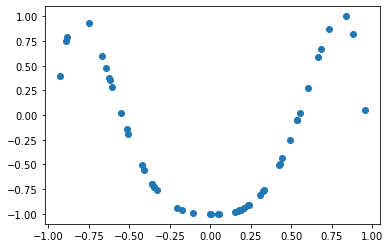

In [6]:
fig = plt.figure()
plt.scatter(domain_train, train_set)
plt.show()

In [7]:
cir = ansatz(layers)

In [8]:
%%time
params = train(domain_train, train_set, cir, layers, method='L-BFGS-B')

CPU times: user 30.4 s, sys: 468 ms, total: 30.8 s
Wall time: 30.4 s


In [9]:
domain_test = np.random.uniform(-1,1,100)
test_set = get_set(poly, domain_test)

In [10]:
%%time
guess = evaluate(cir, params, domain_test)

CPU times: user 47.6 ms, sys: 4.1 ms, total: 51.7 ms
Wall time: 49.4 ms


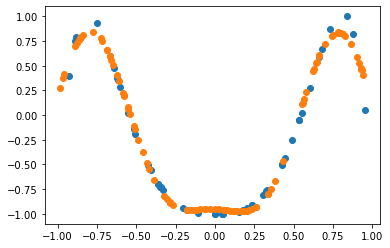

In [11]:
fig = plt.figure()
plt.scatter(domain_train, train_set)
plt.scatter(domain_test, guess)
plt.show()

In [12]:
layers = 8
cir = ansatz(layers)

In [13]:
params_8 = [-1.01998419e-02,  8.39875511e-01,  6.23198511e-01,  1.59240026e-03,
  1.93281677e+00,  6.40394108e-01,  6.49093013e-02,  2.01085133e+00,
  5.68015993e-01, -1.71962213e-01,  1.70355851e+00,  1.52630622e-01,
 -1.77253119e-02,  1.78128656e+00,  2.54809605e+00, -4.08334000e-01,
 -9.56465072e-01, -8.95175410e-01,  2.42801319e+00, -7.01053829e-01,
 -4.97097679e-01,  1.16572700e+00, -2.25838279e-01,  2.37050273e+00]

In [14]:
domain_test = np.random.uniform(-1,1,100)
test_set = get_set(poly, domain_test)

In [15]:
%%time
guess = evaluate(cir, params_8, domain_test)

CPU times: user 60.7 ms, sys: 4.04 ms, total: 64.8 ms
Wall time: 61.9 ms


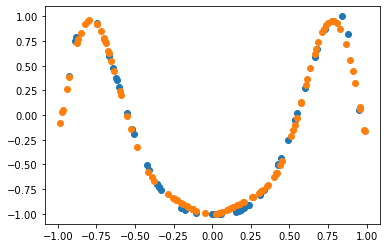

In [16]:
fig = plt.figure()
plt.scatter(domain_train, train_set)
plt.scatter(domain_test, guess)
plt.show()

## One-qubit re-uploading classifier

In [17]:
def create_dataset(num):
    '''Creates and lables the dataset of random points in a plane in/out of a circle of half area.
    Args:
        num (int): number of random points to generate.
        
    Returns:
        [data, labels] (np.array): (x, y) coordinates of points in a plane with [0, 1] labels for 
                                inside/outside the circle.
    
    '''
    data = (-1 + 2*np.random.rand(num, 2))
    labels = []
    for x in data:
        r = x[0]**2+x[1]**2
        if r <= 2/np.pi:
            labels.append(0)
        else:
            labels.append(1)
    return [data, np.array(labels)]


def plot_set(dataset, save=False, name=None):
    '''Plots a given dataset with the corresponding circle with different colors for labelled in/out.
    Args:
        dataset (np.array): (x, y) coordinates of points in a plane with [0, 1] labels for 
                                inside/outside the circle.
        save (Bool): whether to save the figure.
        name (str): distinctive name to save the figure to.

    Returns:
        plot of the dataset points color coded whether labelled inside or outside the circle.
    
    '''
    x_in = []
    y_in = []
    x_out = []
    y_out = []
    for i in range(len(dataset[0])):
        if dataset[1][i] == 0:
            x_in.append(dataset[0][i][0])
            y_in.append(dataset[0][i][1])
        else:
            x_out.append(dataset[0][i][0])
            y_out.append(dataset[0][i][1])
    fig, ax = plt.subplots(figsize=(5, 5))
    circle = plt.Circle((0, 0), np.sqrt(2 / np.pi), color='black', fill=False, zorder=10)
    ax.add_artist(circle)
    ax.scatter(x_in, y_in)
    ax.scatter(x_out, y_out)
    if save:
        plt.savefig(f'classification_result_{name}.png', dpi=300, format='png', bbox_inches='tight')
    plt.show()

def ansatz(layers):
    '''Create the variational quantum circuit to optimize.
    Args:
        layers (int): number of layers for the variational circuit.
        
    Returns:
        c (qibo.models.Circuit): ansatz circuit with parameterized gates.
    
    '''
    c = Circuit(1)
    for l in range(layers):
        c.add(gates.RY(0, theta=0))
        c.add(gates.RZ(0, theta=0))
    c.add(gates.M(0))
    return c


def circuit(c, params, x):
    '''Sets the parameters to the variational circuit with a given input x.
    Args:
        c (qibo.models.Circuit): ansatz circuit with parameterized gates.
        params (np.array): variational parameters to optimize.
        x (np.array): (x, y) points on the plane of the coordinate to classify.
        
    Returns:
        c (qibo.models.Circuit): circuit with the set optmization parameters.
    
    '''
    c_params = []
    for i in range(0, len(params), 4):
        c_params.append(params[i]*x[0]+params[i+1])
        c_params.append(params[i+2]*x[1]+params[i+3])
    c.set_parameters(c_params)
    return c


def cost_one(params, c, x, label):
    '''Cost function for a single coordinate.
    Args:
        params (np.array): variational parameters to optimize.
        c (qibo.models.Circuit): ansatz circuit with parameterized gates.
        x (np.array): (x, y) points on the plane of the coordinate to classify.
        label (int): known location of the coordinate. 0 for inside the circle, 1 for inside.
        
    Returns:
        cost (float): value that characterizes how close the classification was to the optimial.
    
    '''
    #print('before c')
    cir = circuit(c, params, x)
    #print('after c')
    probs = cir(nshots=1024).probabilities(qubits=[0])
    cost = .5*(1-(probs[label]))**2
    return cost


def cost_all(params, c, training_set):
    '''Cost function for all the coordinates of the training set.
    Args:
        params (np.array): variational parameters to optimize.
        c (qibo.models.Circuit): ansatz circuit with parameterized gates.
        training_set (np.array): (x, y) coordinates of points in a plane with [0, 1] labels for 
                                 inside/outside the circle.
    
    Returns:
        cost (float): combined cost function of how close the overall classification was.
        
    '''
    cost = 0
    for x, label in zip(training_set[0], training_set[1]):
        cost += cost_one(params, c, x, label)
    cost /= len(training_set[0])
    return cost


def evaluate(c, params, test_set):
    '''Evaluation of the training set with given parameters.
    Args:
        c (qibo.models.Circuit): ansatz circuit with parameterized gates.
        params (np.array): optimized parameters.
        test_set (np.array): (x, y) coordinates of points in a plane.
    
    Returns:
        guess (np.array): guesses of the classifier based on the output of the quantum circuit.
    
    '''
    guess = []
    for x in test_set:
        cir = circuit(c, params, x)
        probs = cir(nshots=1024).probabilities(qubits=[0])
        guess.append(np.argmax(probs))
    return np.array(guess)


def accuracy(guess, test_labels):
    '''Accuracy of the test set fivent he known labels of the coordinates.
    Args:
        guess (np.array): guesses of the classifier based on the output of the quantum circuit.
        test_labels (int): known location of the coordinates. 0 for inside the circle, 1 for inside.
        
    Returns:
        accuracy (float): percentage of the test set that has been labelled correctly.
        
    '''
    correct = guess==test_labels
    return np.sum(correct)/len(correct)


def train(training_set, c, layers, method='L-BFGS-B'):
    '''Train a given set of coordinates with a 1 qubit variational circuit.
    Args:
        training_set (np.array): (x, y) coordinates of points in a plane with [0, 1] labels for 
                                 inside/outside the circle.
        c (qibo.models.Circuit): ansatz circuit with parameterized gates.
        layers (int): number of layers for the variational circuit.
        method (str): optimization scheme to use.
        
    Returns:
        parameters (np.array): optimized parameters for classification.
        
    {'fun': r[1], 'x': r[0], 'nfev': r[2], 'nit': r[4], 'xmean': r[5], 'stds': r[6]}
    
    '''
    #np.random.seed(0)
    init = np.random.rand(4*layers)
    result, parameters, extra = optimize(cost_all, init, args=(c, training_set),
                                         method='L-BFGS-B', options={'maxiter': 60, 'disp': True})
    return parameters

In [18]:
layers = 5
train_num = 200
test_num = 500

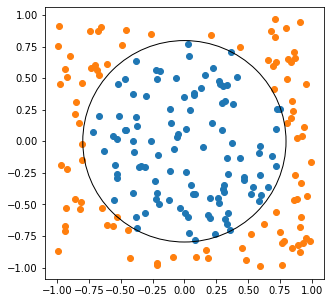

In [19]:
training_set = create_dataset(train_num)
plot_set(training_set)

In [20]:
c = ansatz(layers)

In [21]:
%%time
params = train(training_set, c, layers)

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           20     M =           10

At X0         0 variables are exactly at the bounds


 This problem is unconstrained.



At iterate    0    f=  1.88005D-01    |proj g|=  6.43227D-02

At iterate    1    f=  1.54332D-01    |proj g|=  5.71716D-02

At iterate    2    f=  1.19740D-01    |proj g|=  2.81147D-02

At iterate    3    f=  1.13742D-01    |proj g|=  6.12842D-02

At iterate    4    f=  1.02903D-01    |proj g|=  2.03194D-02

At iterate    5    f=  9.88222D-02    |proj g|=  2.03267D-02

At iterate    6    f=  8.38035D-02    |proj g|=  2.61144D-02

At iterate    7    f=  6.84262D-02    |proj g|=  2.92827D-02

At iterate    8    f=  6.00062D-02    |proj g|=  2.27611D-02

At iterate    9    f=  5.34721D-02    |proj g|=  7.93929D-03

At iterate   10    f=  5.09220D-02    |proj g|=  9.09787D-03

At iterate   11    f=  4.83541D-02    |proj g|=  5.97361D-03

At iterate   12    f=  4.60349D-02    |proj g|=  5.97682D-03

At iterate   13    f=  4.15491D-02    |proj g|=  1.04408D-02

At iterate   14    f=  3.87388D-02    |proj g|=  8.20304D-03

At iterate   15    f=  3.79496D-02    |proj g|=  5.72256D-03

At iter

In [22]:
test_set = create_dataset(test_num)

In [23]:
%%time
guess = evaluate(c, params, test_set[0])

CPU times: user 214 ms, sys: 4.12 ms, total: 218 ms
Wall time: 207 ms


In [24]:
acc = accuracy(guess, test_set[1])
print(f'Accuracy reached for the test set: {acc*100}%')

Accuracy reached for the test set: 94.0%


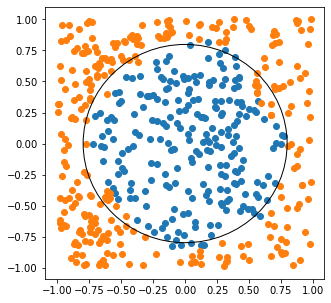

In [25]:
plot_set([test_set[0], guess])